### requirements

In [11]:
!pip install transformers
!pip install accelerate

### loading model

In [12]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", torch_dtype="auto", device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
params_dict = {}
for name, param in model.named_parameters():
  params_dict[name] = param

for name, param in model.named_parameters():
    print(name, param.shape)

transformer.wte.weight torch.Size([50400, 4096])
transformer.h.0.ln_1.weight torch.Size([4096])
transformer.h.0.ln_1.bias torch.Size([4096])
transformer.h.0.attn.k_proj.weight torch.Size([4096, 4096])
transformer.h.0.attn.v_proj.weight torch.Size([4096, 4096])
transformer.h.0.attn.q_proj.weight torch.Size([4096, 4096])
transformer.h.0.attn.out_proj.weight torch.Size([4096, 4096])
transformer.h.0.mlp.fc_in.weight torch.Size([16384, 4096])
transformer.h.0.mlp.fc_in.bias torch.Size([16384])
transformer.h.0.mlp.fc_out.weight torch.Size([4096, 16384])
transformer.h.0.mlp.fc_out.bias torch.Size([4096])
transformer.h.1.ln_1.weight torch.Size([4096])
transformer.h.1.ln_1.bias torch.Size([4096])
transformer.h.1.attn.k_proj.weight torch.Size([4096, 4096])
transformer.h.1.attn.v_proj.weight torch.Size([4096, 4096])
transformer.h.1.attn.q_proj.weight torch.Size([4096, 4096])
transformer.h.1.attn.out_proj.weight torch.Size([4096, 4096])
transformer.h.1.mlp.fc_in.weight torch.Size([16384, 4096])
tra

## Nuclear Norm Explorartion

### Calc and Graph Nuclear Norm Code

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def k_rank_nuclear_norm(matrix_name, squared = True):
  matrix = params_dict[matrix_name]
  U, S, V = torch.svd(matrix)

  total_sum = 0
  for sv in S:
    if squared: total_sum += sv.item()**2
    else: total_sum += sv.item()

  k_rank_info = []
  k_rank_sum = 0
  for sv in S:
    if squared: k_rank_sum += sv.item()**2
    else: k_rank_sum += sv.item()
    k_rank_info.append(k_rank_sum/total_sum)

  return k_rank_info

def plot_nuclear_norm(matrix_name, printouts = None, visualize_k = None, squared = True):
  matrix = params_dict[matrix_name]
  U, S, V = torch.svd(matrix)

  k_rank_info = k_rank_nuclear_norm(matrix_name, squared)

  if printouts:
    for k in printouts:
      print(f"rank-{k} info: {k_rank_info[k-1]}")

  if not visualize_k:
    visualize_k = len(k_rank_info)

  xpoints = [idx+1 for idx in range(len(k_rank_info))][:visualize_k]
  ypoints = k_rank_info[:visualize_k]

  num_ticks_x = 10
  plt.xticks(range(1, len(xpoints)+1, len(xpoints)//num_ticks_x))

  num_ticks_y = 10
  plt.yticks(np.linspace(min(ypoints), max(ypoints), num_ticks_y))

  plt.grid(True)
  plt.xlabel('k-Rank')
  plt.ylabel('% Information')
  plt.plot(xpoints, ypoints)

  plt.show()
  return

def mult_plot(lines, names = None, cutoff=None):
  for idx, l in enumerate(lines):
    xpoints = [idx+1 for idx in range(len(l))]
    ypoints = l

    if cutoff:
      xpoints = xpoints[:cutoff]
      ypoints = ypoints[:cutoff]

    if names:
      plt.plot(xpoints, ypoints, label=names[idx])
    else:
      plt.plot(xpoints, ypoints, label=f'{idx}')

  plt.legend()
  plt.grid(True)
  plt.show()
  return

### MLP Out Layers

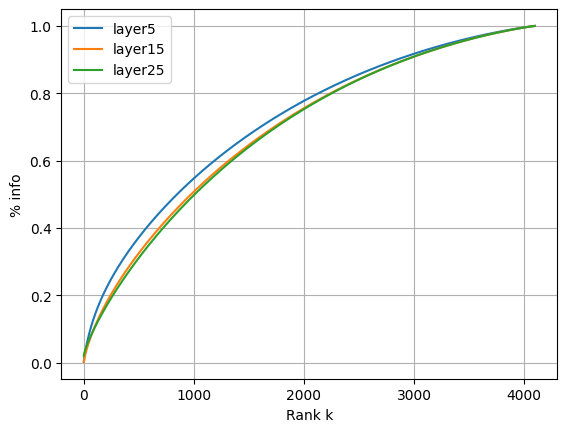

In [ ]:
k_rank_info_5 = k_rank_nuclear_norm('transformer.h.5.mlp.fc_out.weight')
k_rank_info_15 = k_rank_nuclear_norm('transformer.h.15.mlp.fc_out.weight')
k_rank_info_25= k_rank_nuclear_norm('transformer.h.25.mlp.fc_out.weight')

plt.xlabel("Rank k")
plt.ylabel("% info")

mult_plot([k_rank_info_5, k_rank_info_15, k_rank_info_25], ['layer5', 'layer15', 'layer25'])

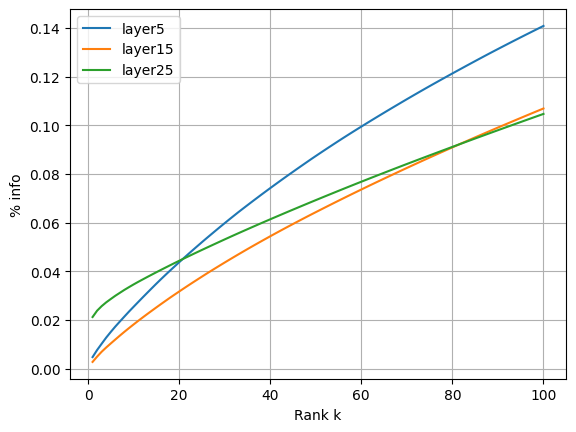

In [ ]:
rank_k = 100

k_rank_info_5 = k_rank_nuclear_norm('transformer.h.5.mlp.fc_out.weight')
k_rank_info_15 = k_rank_nuclear_norm('transformer.h.15.mlp.fc_out.weight')
k_rank_info_25 = k_rank_nuclear_norm('transformer.h.25.mlp.fc_out.weight')

plt.xlabel("Rank k")
plt.ylabel("% info")

mult_plot([k_rank_info_5, k_rank_info_15, k_rank_info_25], ['layer5', 'layer15', 'layer25'], cutoff=rank_k)

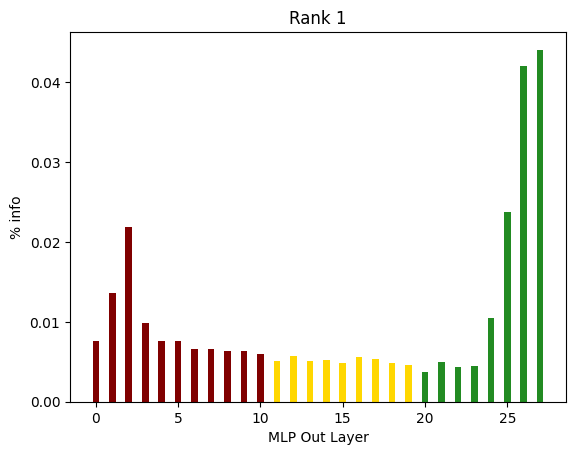

In [ ]:
rank_k = 1

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_out.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

colors = []
for _ in range(11): colors.append('maroon')
for _ in range(9): colors.append('gold')
for _ in range(8): colors.append('forestgreen')

# creating the bar plot
plt.bar(xvalues, yvalues, color = colors,
        width = 0.4)

plt.xlabel("MLP Out Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

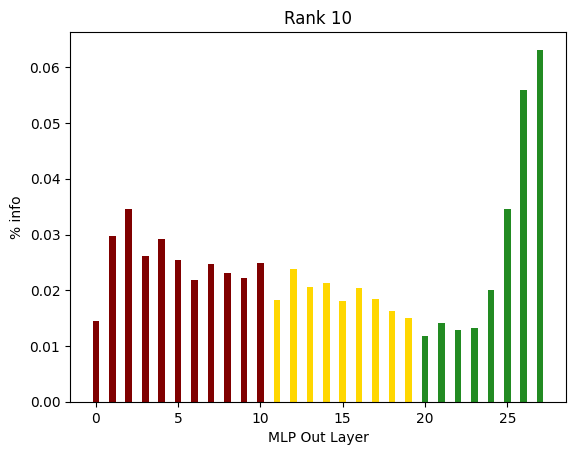

In [ ]:
rank_k = 10

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_out.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

colors = []
for _ in range(11): colors.append('maroon')
for _ in range(9): colors.append('gold')
for _ in range(8): colors.append('forestgreen')

# creating the bar plot
plt.bar(xvalues, yvalues, color = colors,
        width = 0.4)

plt.xlabel("MLP Out Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

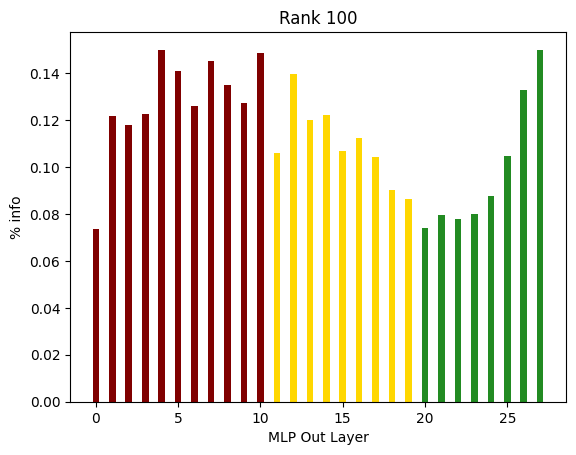

In [ ]:
rank_k = 100

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_out.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

colors = []
for _ in range(11): colors.append('maroon')
for _ in range(9): colors.append('gold')
for _ in range(8): colors.append('forestgreen')

# creating the bar plot
plt.bar(xvalues, yvalues, color = colors,
        width = 0.4)

plt.xlabel("MLP Out Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

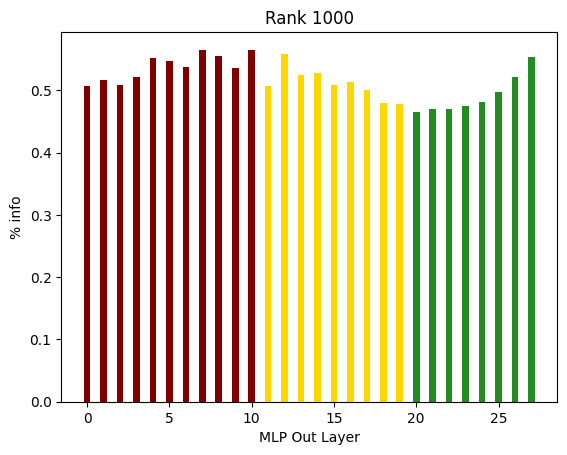

In [ ]:
rank_k = 1000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_out.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

colors = []
for _ in range(11): colors.append('maroon')
for _ in range(9): colors.append('gold')
for _ in range(8): colors.append('forestgreen')

# creating the bar plot
plt.bar(xvalues, yvalues, color = colors,
        width = 0.4)

plt.xlabel("MLP Out Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

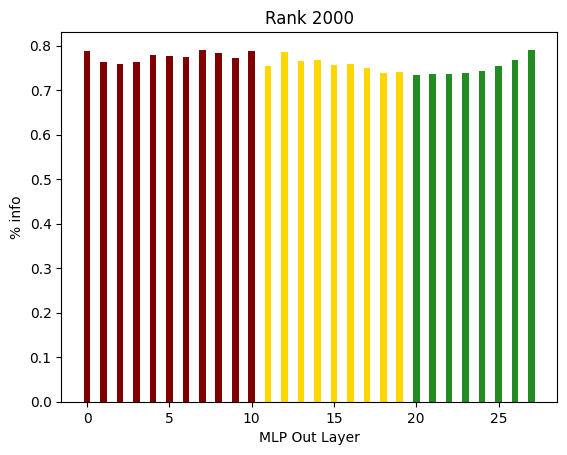

In [ ]:
rank_k = 2000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_out.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

colors = []
for _ in range(11): colors.append('maroon')
for _ in range(9): colors.append('gold')
for _ in range(8): colors.append('forestgreen')

# creating the bar plot
plt.bar(xvalues, yvalues, color = colors,
        width = 0.4)

plt.xlabel("MLP Out Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

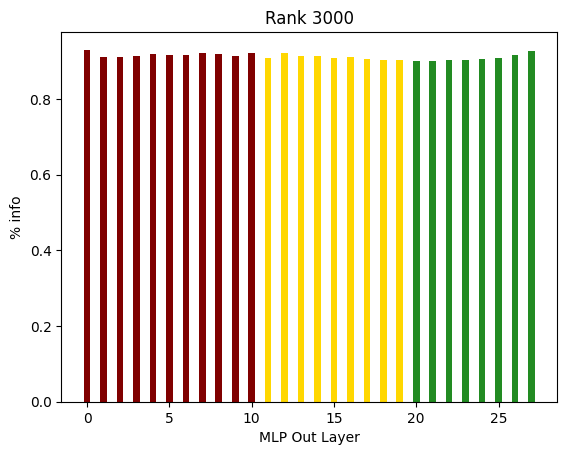

In [ ]:
rank_k = 3000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_out.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

colors = []
for _ in range(11): colors.append('maroon')
for _ in range(9): colors.append('gold')
for _ in range(8): colors.append('forestgreen')

# creating the bar plot
plt.bar(xvalues, yvalues, color = colors,
        width = 0.4)

plt.xlabel("MLP Out Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

### MLP In Layers

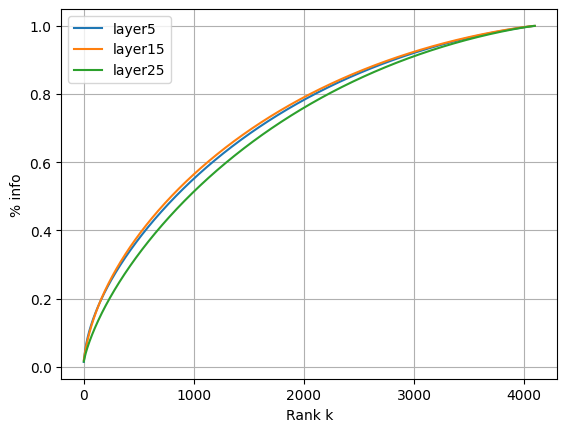

In [ ]:
k_rank_info_5 = k_rank_nuclear_norm('transformer.h.5.mlp.fc_in.weight')
k_rank_info_15 = k_rank_nuclear_norm('transformer.h.15.mlp.fc_in.weight')
k_rank_info_25= k_rank_nuclear_norm('transformer.h.25.mlp.fc_in.weight')

plt.xlabel("Rank k")
plt.ylabel("% info")

mult_plot([k_rank_info_5, k_rank_info_15, k_rank_info_25], ['layer5', 'layer15', 'layer25'])

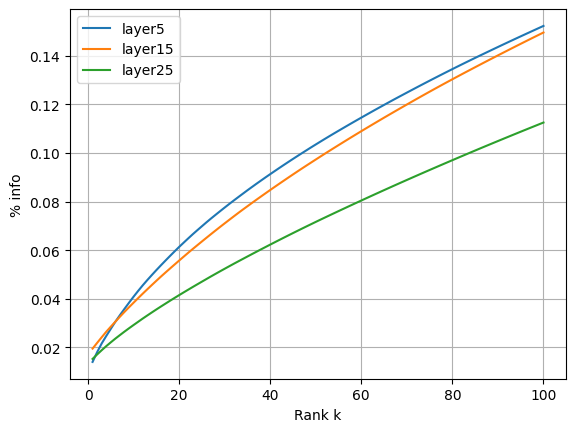

In [ ]:
rank_k = 100

k_rank_info_5 = k_rank_nuclear_norm('transformer.h.5.mlp.fc_in.weight')
k_rank_info_15 = k_rank_nuclear_norm('transformer.h.15.mlp.fc_in.weight')
k_rank_info_25 = k_rank_nuclear_norm('transformer.h.25.mlp.fc_in.weight')

plt.xlabel("Rank k")
plt.ylabel("% info")

mult_plot([k_rank_info_5, k_rank_info_15, k_rank_info_25], ['layer5', 'layer15', 'layer25'], cutoff=rank_k)

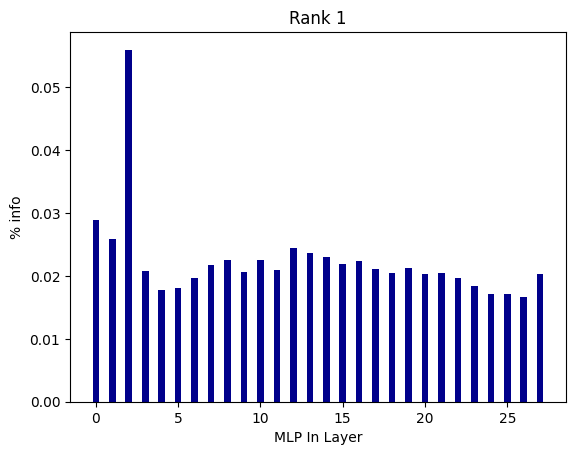

In [ ]:
rank_k = 1

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_in.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("MLP In Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

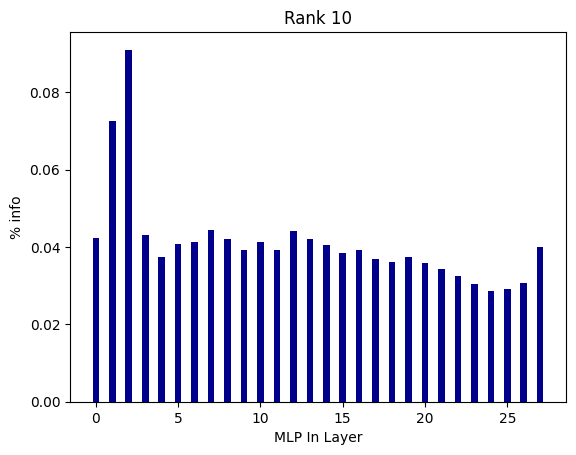

In [ ]:
rank_k = 10

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_in.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("MLP In Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

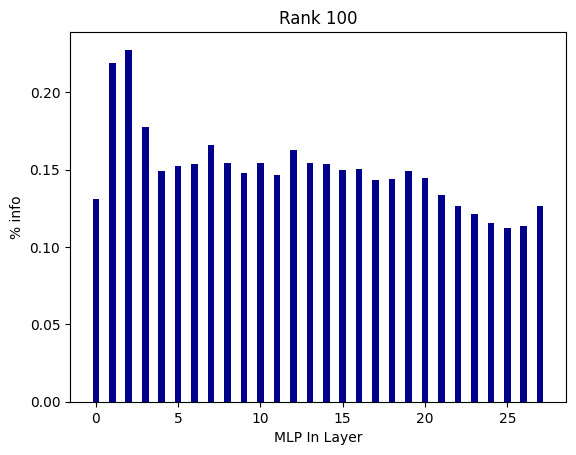

In [ ]:
rank_k = 100

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_in.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("MLP In Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

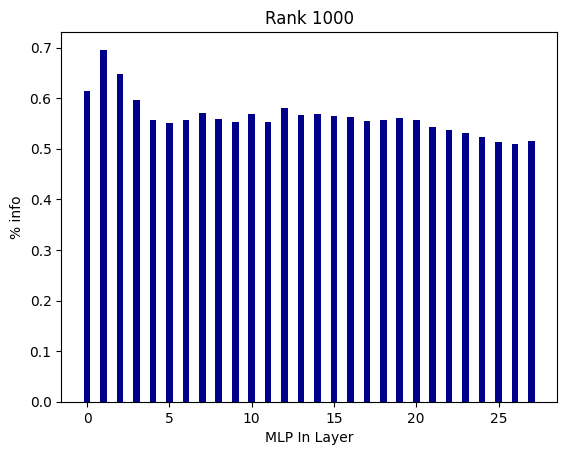

In [ ]:
rank_k = 1000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_in.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("MLP In Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

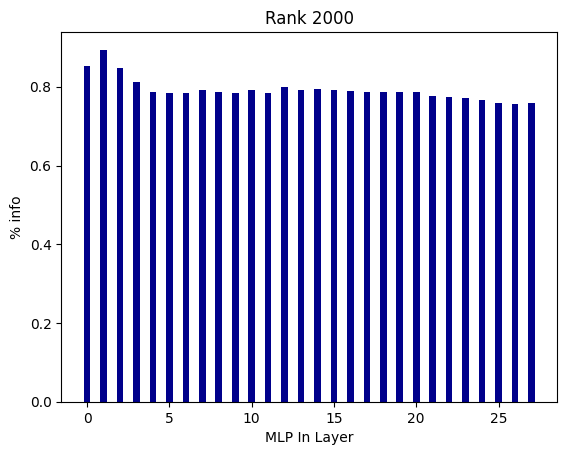

In [ ]:
rank_k = 2000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_in.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("MLP In Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

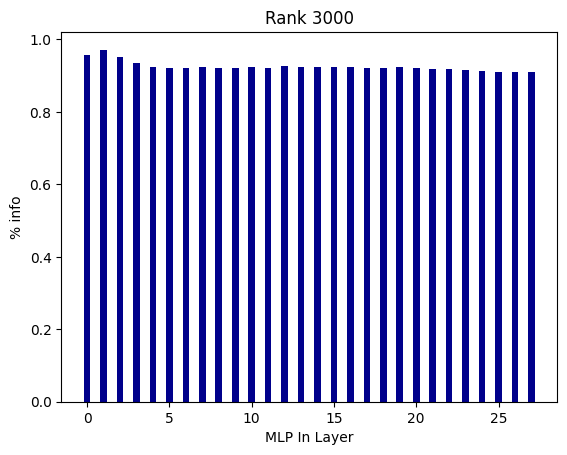

In [ ]:
rank_k = 3000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.mlp.fc_in.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("MLP In Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

### Attention Key Layers

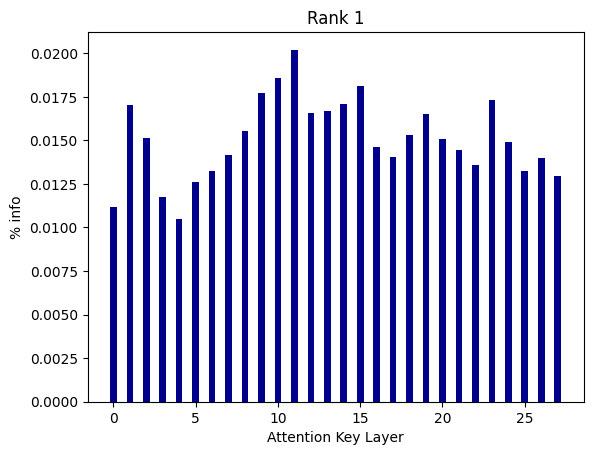

In [ ]:
rank_k = 1

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.attn.k_proj.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("Attention Key Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

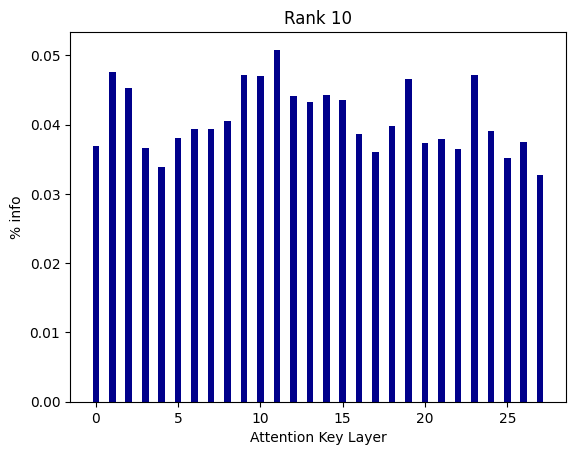

In [ ]:
rank_k = 10

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.attn.k_proj.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("Attention Key Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

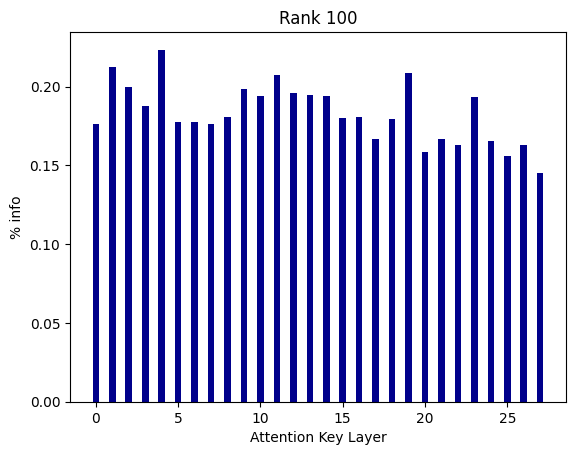

In [ ]:
rank_k = 100

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.attn.k_proj.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("Attention Key Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

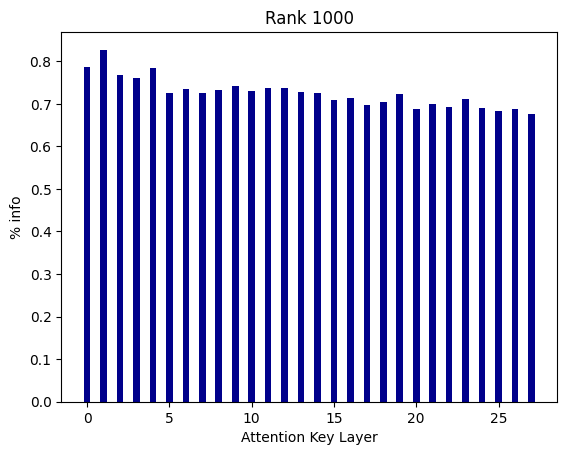

In [ ]:
rank_k = 1000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.attn.k_proj.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("Attention Key Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

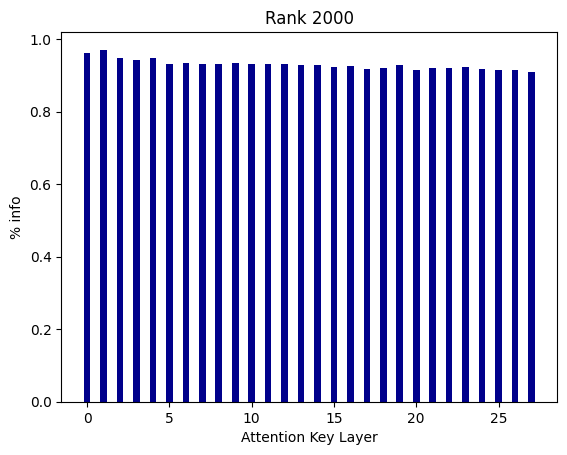

In [ ]:
rank_k = 2000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.attn.k_proj.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("Attention Key Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

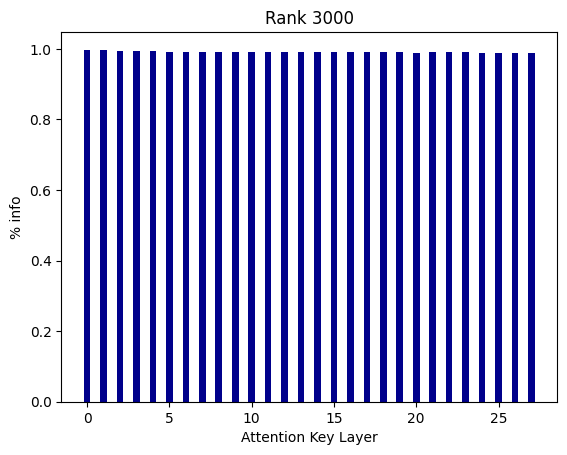

In [ ]:
rank_k = 3000

names = []
for idx in range(28):
  names.append(f'transformer.h.{idx}.attn.k_proj.weight')

yvalues = [k_rank_nuclear_norm(n)[rank_k-1] for n in names]
xvalues = [idx for idx in range(len(yvalues))]

# creating the bar plot
plt.bar(xvalues, yvalues, color = 'darkblue',
        width = 0.4)

plt.xlabel("Attention Key Layer")
plt.ylabel("% info")
plt.title(f"Rank {rank_k}")
plt.show()

## Shared Subspaces Explorartion

### Subspace investigation code

In [3]:
import numpy as np
from numpy.linalg import matrix_rank
from numpy.linalg import svd
from numpy.linalg import norm
import torch

In [4]:
def cuda2cpu_tensor2numpy(torch_a):
  torch_a = torch_a.cpu()
  return torch_a.detach().numpy()

def remove_zeroed_col(matrix):
  keep_cols = []
  for col_idx in range(len(matrix[0])):
    if sum(matrix[:, col_idx]) != 0: keep_cols.append(col_idx)

  return matrix[:, keep_cols]

def remove_zeroed_row(matrix):
  keep_rows = []
  for row_idx in range(len(matrix)):
    if sum(matrix[row_idx]) != 0: keep_rows.append(row_idx)

  return matrix[keep_rows]

def find_threshold(matrix, percentage):
    # Flatten the matrix
    flattened_matrix = np.absolute(matrix.flatten())

    # Sort the values
    sorted_values = np.sort(flattened_matrix)

    # Find the index corresponding to the xth percentile
    index = int(len(sorted_values) * percentage)

    # Get the threshold value
    threshold = sorted_values[index]

    return threshold

def numerical_rank(matrix, threshold):
  abs_matrix = np.absolute(matrix)
  mask = np.ma.masked_less(abs_matrix, threshold).mask
  matrix[mask] = 0
  return matrix

def filter_matrix(matrix, threshold):
  # supressing values that are below the threshold
  matrix = numerical_rank(matrix, threshold)

  # removing all-zero columns
  # matrix = remove_zeroed_row(matrix)

  # rounding
  # matrix = np.around(matrix, 2)

  return matrix


def compare_subspace(matrix1, matrix2, threshold, adaptive_threshold):
  # finding the threshold if it is adaptive
  if adaptive_threshold: threshold = find_threshold(matrix1, adaptive_threshold)

  # supressing values that are below the threshold
  matrix1 = filter_matrix(matrix1, threshold)
  matrix2 = filter_matrix(matrix2, threshold)

  matrix1_rank = matrix_rank(matrix1)
  matrix2_rank = matrix_rank(matrix2)

  # calc the rank if there is not shared subspace
  matrix1_matrix2_fullrank = matrix1_rank + matrix2_rank

  # calc real rank of shared subspace
  matrix1_matrix2 = np.concatenate((matrix1, matrix2), axis=0)

  matrix1_matrix2_rank = matrix_rank(matrix1_matrix2)

  print(f'fullrank_components: {(matrix1_rank, matrix2_rank)}, actual rank: {matrix1_matrix2_rank}, threshold used: {threshold}')

  return {'percentage': matrix1_matrix2_rank / matrix1_matrix2_fullrank}


# def compare_subspace(matrix1, matrix2, threshold, adaptive_threshold):
#   # supressing values that are below the threshold
#   matrix1 = numerical_rank(matrix1, threshold)
#   matrix2 = numerical_rank(matrix2, threshold)

#   # finding the rank of the subspace
#   matrix1_rank = matrix_rank(matrix1)
#   matrix2_rank = matrix_rank(matrix2)

#   # calc the rank if there is not shared subspace
#   matrix1_matrix2_fullrank = matrix1_rank + matrix2_rank

#   # calc real rank of shared subspace
#   matrix1_matrix2 = np.concatenate((matrix1, matrix2), axis=0)
#   matrix1_matrix2_rank = matrix_rank(matrix1_matrix2)

#   print(f'fullrank_components: {(matrix1_rank, matrix2_rank)}, actual rank: {matrix1_matrix2_rank}, threshold used: {threshold}')
#   return {'percentage': matrix1_matrix2_rank / matrix1_matrix2_fullrank}

In [5]:
from tqdm import tqdm

def compare_all_subspaces(layer_names, threshold = 0.06, adaptive_threshold = None, v_matrix = True):
  spaces_lst = []
  for idx in tqdm(range(len(layer_names)-1)):
    m1 = params_dict[layer_names[idx]]
    m2 = params_dict[layer_names[idx+1]]

    U1, S1, V1 = torch.svd(m1)
    U2, S2, V2 = torch.svd(m2)

    if v_matrix:
      m1 = cuda2cpu_tensor2numpy(V1)
      m2 = cuda2cpu_tensor2numpy(V2)
    else:
      m1 = cuda2cpu_tensor2numpy(U1)
      m2 = cuda2cpu_tensor2numpy(U2)

    spaces_lst.append(compare_subspace(m1, m2, threshold = threshold, adaptive_threshold = adaptive_threshold))

  return spaces_lst

In [6]:
import matplotlib.pyplot as plt

def basic_plot(xpoints, ypoints, xlabel = None, ylabel = None):
  num_ticks_x = len(xpoints)
  plt.xticks(range(1, len(xpoints)+1, len(xpoints)//num_ticks_x))

  num_ticks_y = 10
  plt.yticks(np.linspace(min(ypoints), max(ypoints), num_ticks_y))

  plt.grid(True)

  if xlabel: plt.xlabel(xlabel)
  if ylabel: plt.ylabel(ylabel)

  plt.plot(xpoints, ypoints)

  plt.show()
  return

### Col Rank V

In [9]:
# comparing subspaces of mlp out
layer_names = [f'transformer.h.{idx}.mlp.fc_out.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, adaptive_threshold = 0.999999)

  4%|▎         | 1/27 [01:09<29:58, 69.18s/it]

fullrank_components: (14, 23), actual rank: 32, threshold used: 0.06442961096763611


  7%|▋         | 2/27 [02:19<29:00, 69.61s/it]

fullrank_components: (17, 20), actual rank: 33, threshold used: 0.07330142706632614


 11%|█         | 3/27 [03:27<27:41, 69.22s/it]

fullrank_components: (10, 8), actual rank: 16, threshold used: 0.08419004082679749


 15%|█▍        | 4/27 [04:36<26:27, 69.03s/it]

fullrank_components: (21, 22), actual rank: 37, threshold used: 0.0630684420466423


 19%|█▊        | 5/27 [05:46<25:26, 69.39s/it]

fullrank_components: (20, 16), actual rank: 34, threshold used: 0.06593908369541168


 22%|██▏       | 6/27 [06:53<23:59, 68.57s/it]

fullrank_components: (21, 22), actual rank: 38, threshold used: 0.06248636543750763


 26%|██▌       | 7/27 [08:01<22:44, 68.24s/it]

fullrank_components: (32, 30), actual rank: 57, threshold used: 0.06023592874407768


 30%|██▉       | 8/27 [09:11<21:46, 68.79s/it]

fullrank_components: (46, 58), actual rank: 102, threshold used: 0.05761014670133591


 33%|███▎      | 9/27 [10:18<20:32, 68.46s/it]

fullrank_components: (22, 22), actual rank: 42, threshold used: 0.0696575865149498


 37%|███▋      | 10/27 [11:26<19:19, 68.22s/it]

fullrank_components: (27, 18), actual rank: 43, threshold used: 0.06537778675556183


 41%|████      | 11/27 [12:36<18:18, 68.69s/it]

fullrank_components: (27, 63), actual rank: 88, threshold used: 0.06278518587350845


 44%|████▍     | 12/27 [13:45<17:11, 68.76s/it]

fullrank_components: (25, 12), actual rank: 36, threshold used: 0.07181919366121292


 48%|████▊     | 13/27 [14:52<15:57, 68.39s/it]

fullrank_components: (30, 68), actual rank: 94, threshold used: 0.06171607971191406


 52%|█████▏    | 14/27 [16:03<14:56, 68.99s/it]

fullrank_components: (30, 18), actual rank: 46, threshold used: 0.0716044083237648


 56%|█████▌    | 15/27 [17:11<13:46, 68.85s/it]

fullrank_components: (27, 55), actual rank: 76, threshold used: 0.06787695735692978


 59%|█████▉    | 16/27 [18:18<12:29, 68.15s/it]

fullrank_components: (34, 41), actual rank: 71, threshold used: 0.07192298024892807


 63%|██████▎   | 17/27 [19:28<11:26, 68.67s/it]

fullrank_components: (35, 50), actual rank: 78, threshold used: 0.07519065588712692


 67%|██████▋   | 18/27 [20:35<10:13, 68.17s/it]

fullrank_components: (38, 40), actual rank: 74, threshold used: 0.0782458558678627


 70%|███████   | 19/27 [21:43<09:05, 68.16s/it]

fullrank_components: (29, 18), actual rank: 44, threshold used: 0.08780688047409058


 74%|███████▍  | 20/27 [22:50<07:54, 67.84s/it]

fullrank_components: (32, 36), actual rank: 63, threshold used: 0.07968322932720184


 78%|███████▊  | 21/27 [23:57<06:45, 67.62s/it]

fullrank_components: (25, 56), actual rank: 74, threshold used: 0.08623038977384567


 81%|████████▏ | 22/27 [25:07<05:41, 68.25s/it]

fullrank_components: (33, 25), actual rank: 49, threshold used: 0.10553140193223953


 85%|████████▌ | 23/27 [26:15<04:32, 68.22s/it]

fullrank_components: (26, 33), actual rank: 49, threshold used: 0.10399685055017471


 89%|████████▉ | 24/27 [27:22<03:23, 67.84s/it]

fullrank_components: (31, 50), actual rank: 69, threshold used: 0.10834084451198578


 93%|█████████▎| 25/27 [28:30<02:16, 68.04s/it]

fullrank_components: (23, 43), actual rank: 54, threshold used: 0.1390247941017151


 96%|█████████▋| 26/27 [29:38<01:08, 68.03s/it]

fullrank_components: (34, 53), actual rank: 76, threshold used: 0.15336832404136658


100%|██████████| 27/27 [30:47<00:00, 68.41s/it]

fullrank_components: (36, 40), actual rank: 70, threshold used: 0.17681613564491272


[0.8648648648648649, 0.8918918918918919, 0.8888888888888888, 0.8604651162790697, 0.9444444444444444, 0.8837209302325582, 0.9193548387096774, 0.9807692307692307, 0.9545454545454546, 0.9555555555555556, 0.9777777777777777, 0.972972972972973, 0.9591836734693877, 0.9583333333333334, 0.926829268292683, 0.9466666666666667, 0.9176470588235294, 0.9487179487179487, 0.9361702127659575, 0.9264705882352942, 0.9135802469135802, 0.8448275862068966, 0.8305084745762712, 0.8518518518518519, 0.8181818181818182, 0.8735632183908046, 0.9210526315789473]


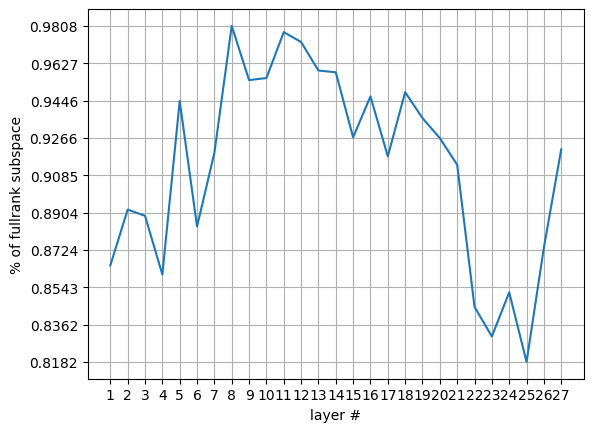

In [10]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
print(ypoints)
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

In [120]:
# comparing subspaces of mlp out
layer_names = [f'transformer.h.{idx}.mlp.fc_out.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, adaptive_threshold = 0.9)

  4%|▎         | 1/27 [01:19<34:21, 79.30s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012828332372009754


  7%|▋         | 2/27 [02:28<30:33, 73.35s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01283512357622385


 11%|█         | 3/27 [03:38<28:46, 71.92s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01284340675920248


 15%|█▍        | 4/27 [04:47<27:06, 70.72s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012829627841711044


 19%|█▊        | 5/27 [05:55<25:30, 69.56s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012817409820854664


 22%|██▏       | 6/27 [07:05<24:28, 69.91s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012806243263185024


 26%|██▌       | 7/27 [08:13<23:06, 69.33s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01280392799526453


 30%|██▉       | 8/27 [09:21<21:48, 68.89s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012795106507837772


 33%|███▎      | 9/27 [10:31<20:44, 69.13s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01278895977884531


 37%|███▋      | 10/27 [11:42<19:43, 69.59s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012791075743734837


 41%|████      | 11/27 [12:50<18:27, 69.25s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012786071747541428


 44%|████▍     | 12/27 [14:00<17:20, 69.40s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012782403267920017


 48%|████▊     | 13/27 [15:09<16:10, 69.34s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01277873758226633


 52%|█████▏    | 14/27 [16:18<14:58, 69.10s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012769489549100399


 56%|█████▌    | 15/27 [17:26<13:47, 68.92s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012780747376382351


 59%|█████▉    | 16/27 [18:35<12:39, 69.05s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01278313435614109


 63%|██████▎   | 17/27 [19:43<11:27, 68.75s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.01277966145426035


 67%|██████▋   | 18/27 [20:53<10:20, 68.96s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.0127817802131176


 70%|███████   | 19/27 [22:04<09:16, 69.60s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012804286554455757


 74%|███████▍  | 20/27 [23:12<08:03, 69.02s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012806524522602558


 78%|███████▊  | 21/27 [24:19<06:51, 68.53s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012821442447602749


 81%|████████▏ | 22/27 [25:31<05:47, 69.54s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012811346910893917


 85%|████████▌ | 23/27 [26:39<04:36, 69.12s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012820265255868435


 89%|████████▉ | 24/27 [27:47<03:26, 68.78s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012817968614399433


 93%|█████████▎| 25/27 [28:56<02:17, 68.74s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012793758884072304


 96%|█████████▋| 26/27 [30:05<01:09, 69.03s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012753862887620926


100%|██████████| 27/27 [31:13<00:00, 69.39s/it]

fullrank_components: (4096, 4096), actual rank: 4096, threshold used: 0.012737858109176159


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


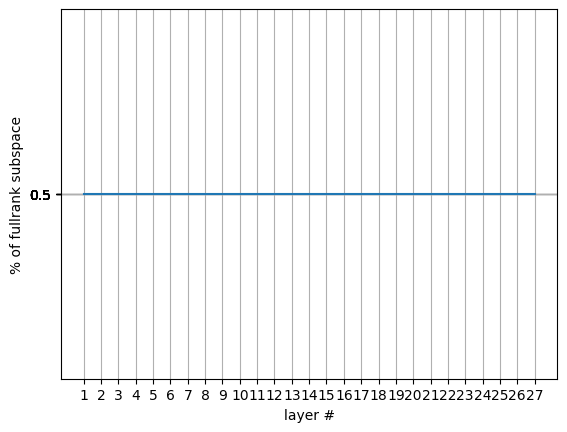

In [121]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
print(ypoints)
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

In [122]:
# comparing subspaces of mlp out
layer_names = [f'transformer.h.{idx}.mlp.fc_out.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, adaptive_threshold = 0.9999)

  4%|▎         | 1/27 [01:07<29:25, 67.92s/it]

fullrank_components: (2837, 2435), actual rank: 3673, threshold used: 0.03225337341427803


  7%|▋         | 2/27 [02:14<27:59, 67.19s/it]

fullrank_components: (2650, 2731), actual rank: 3605, threshold used: 0.031972307711839676


 11%|█         | 3/27 [03:24<27:18, 68.27s/it]

fullrank_components: (2333, 2367), actual rank: 3297, threshold used: 0.03257150575518608


 15%|█▍        | 4/27 [04:30<25:53, 67.53s/it]

fullrank_components: (2521, 2701), actual rank: 3477, threshold used: 0.03240176662802696


 19%|█▊        | 5/27 [05:37<24:44, 67.48s/it]

fullrank_components: (2061, 2143), actual rank: 2942, threshold used: 0.033573783934116364


 22%|██▏       | 6/27 [06:44<23:31, 67.22s/it]

fullrank_components: (1604, 1739), actual rank: 2421, threshold used: 0.03479749709367752


 26%|██▌       | 7/27 [07:53<22:32, 67.64s/it]

fullrank_components: (1716, 1892), actual rank: 2534, threshold used: 0.03486025705933571


 30%|██▉       | 8/27 [08:59<21:15, 67.11s/it]

fullrank_components: (1662, 1699), actual rank: 2371, threshold used: 0.03546643257141113


 33%|███▎      | 9/27 [10:06<20:11, 67.30s/it]

fullrank_components: (1438, 1365), actual rank: 2047, threshold used: 0.0362761914730072


 37%|███▋      | 10/27 [11:12<18:57, 66.92s/it]

fullrank_components: (1574, 1673), actual rank: 2388, threshold used: 0.03556857258081436


 41%|████      | 11/27 [12:21<17:56, 67.29s/it]

fullrank_components: (1415, 1374), actual rank: 2071, threshold used: 0.036424919962882996


 44%|████▍     | 12/27 [13:27<16:43, 66.91s/it]

fullrank_components: (1213, 1383), actual rank: 1900, threshold used: 0.03705822303891182


 48%|████▊     | 13/27 [14:34<15:39, 67.12s/it]

fullrank_components: (1412, 1379), actual rank: 1966, threshold used: 0.03693918138742447


 52%|█████▏    | 14/27 [15:40<14:27, 66.76s/it]

fullrank_components: (1138, 1046), actual rank: 1515, threshold used: 0.03824955224990845


 56%|█████▌    | 15/27 [16:47<13:22, 66.84s/it]

fullrank_components: (1209, 1093), actual rank: 1603, threshold used: 0.0372893325984478


 59%|█████▉    | 16/27 [17:53<12:11, 66.53s/it]

fullrank_components: (1065, 1009), actual rank: 1409, threshold used: 0.03750396519899368


 63%|██████▎   | 17/27 [18:59<11:02, 66.27s/it]

fullrank_components: (915, 839), actual rank: 1184, threshold used: 0.038161538541316986


 67%|██████▋   | 18/27 [20:04<09:53, 65.96s/it]

fullrank_components: (772, 569), actual rank: 959, threshold used: 0.03870057314634323


 70%|███████   | 19/27 [21:11<08:50, 66.37s/it]

fullrank_components: (921, 924), actual rank: 1426, threshold used: 0.03611928969621658


 74%|███████▍  | 20/27 [22:17<07:42, 66.11s/it]

fullrank_components: (927, 698), actual rank: 1326, threshold used: 0.03611019253730774


 78%|███████▊  | 21/27 [23:22<06:36, 66.01s/it]

fullrank_components: (1603, 1635), actual rank: 2596, threshold used: 0.033379025757312775


 81%|████████▏ | 22/27 [24:29<05:31, 66.27s/it]

fullrank_components: (1089, 948), actual rank: 1714, threshold used: 0.03468114882707596


 85%|████████▌ | 23/27 [25:36<04:25, 66.35s/it]

fullrank_components: (1431, 1425), actual rank: 2387, threshold used: 0.0334940180182457


 89%|████████▉ | 24/27 [26:43<03:19, 66.66s/it]

fullrank_components: (1271, 1429), actual rank: 2279, threshold used: 0.033813416957855225


 93%|█████████▎| 25/27 [27:49<02:12, 66.43s/it]

fullrank_components: (544, 745), actual rank: 1046, threshold used: 0.038240838795900345


 96%|█████████▋| 26/27 [28:56<01:06, 66.56s/it]

fullrank_components: (443, 489), actual rank: 651, threshold used: 0.04610617831349373


100%|██████████| 27/27 [30:02<00:00, 66.76s/it]

fullrank_components: (436, 510), actual rank: 644, threshold used: 0.048827413469552994


[0.6966995447647951, 0.6699498234528898, 0.7014893617021276, 0.6658368441210264, 0.6998097050428164, 0.7241998205204906, 0.7023281596452328, 0.7054448080928295, 0.7302889760970389, 0.7354481059439483, 0.7425600573682324, 0.7318952234206472, 0.7044070225725546, 0.6936813186813187, 0.6963509991311903, 0.6793635486981678, 0.6750285062713797, 0.715137956748695, 0.77289972899729, 0.816, 0.8017294626312539, 0.8414334806087383, 0.8357843137254902, 0.8440740740740741, 0.8114817688130334, 0.6984978540772532, 0.6807610993657506]


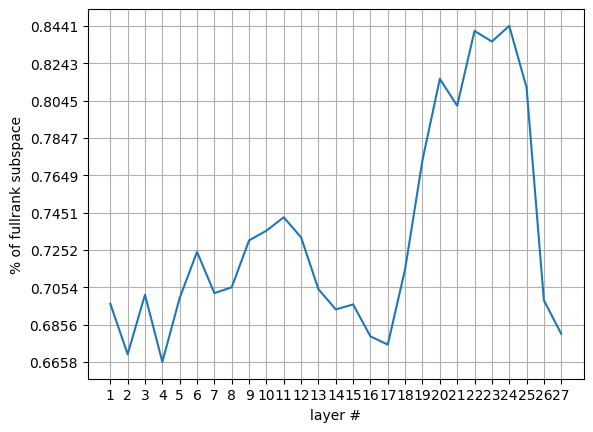

In [123]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
print(ypoints)
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

In [124]:
# comparing subspaces of mlp out
layer_names = [f'transformer.h.{idx}.mlp.fc_out.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, adaptive_threshold = 0.9999999)

  4%|▎         | 1/27 [01:04<27:44, 64.01s/it]

fullrank_components: (3, 5), actual rank: 8, threshold used: 0.11525967717170715


  7%|▋         | 2/27 [02:09<27:03, 64.95s/it]

fullrank_components: (2, 0), actual rank: 2, threshold used: 0.144605815410614


 11%|█         | 3/27 [03:13<25:48, 64.53s/it]

fullrank_components: (5, 5), actual rank: 9, threshold used: 0.10311843454837799


 15%|█▍        | 4/27 [04:16<24:32, 64.02s/it]

fullrank_components: (2, 4), actual rank: 6, threshold used: 0.13404439389705658


 19%|█▊        | 5/27 [05:22<23:38, 64.47s/it]

fullrank_components: (5, 1), actual rank: 5, threshold used: 0.12090315669775009


 22%|██▏       | 6/27 [06:25<22:26, 64.10s/it]

fullrank_components: (4, 3), actual rank: 7, threshold used: 0.09373843669891357


 26%|██▌       | 7/27 [07:28<21:17, 63.87s/it]

fullrank_components: (4, 0), actual rank: 4, threshold used: 0.09315594285726547


 30%|██▉       | 8/27 [08:34<20:23, 64.39s/it]

fullrank_components: (7, 14), actual rank: 21, threshold used: 0.07420773804187775


 33%|███▎      | 9/27 [09:38<19:19, 64.39s/it]

fullrank_components: (3, 2), actual rank: 5, threshold used: 0.09703704714775085


 37%|███▋      | 10/27 [10:41<18:08, 64.00s/it]

fullrank_components: (3, 5), actual rank: 7, threshold used: 0.09215398132801056


 41%|████      | 11/27 [11:46<17:08, 64.27s/it]

fullrank_components: (4, 6), actual rank: 9, threshold used: 0.09383890777826309


 44%|████▍     | 12/27 [12:50<16:00, 64.05s/it]

fullrank_components: (5, 3), actual rank: 7, threshold used: 0.0987517312169075


 48%|████▊     | 13/27 [13:53<14:54, 63.90s/it]

fullrank_components: (5, 7), actual rank: 11, threshold used: 0.09138250350952148


 52%|█████▏    | 14/27 [15:00<13:59, 64.56s/it]

fullrank_components: (5, 3), actual rank: 8, threshold used: 0.10165071487426758


 56%|█████▌    | 15/27 [16:04<12:53, 64.48s/it]

fullrank_components: (3, 5), actual rank: 8, threshold used: 0.1015603095293045


 59%|█████▉    | 16/27 [17:08<11:48, 64.43s/it]

fullrank_components: (5, 5), actual rank: 9, threshold used: 0.10691973567008972


 63%|██████▎   | 17/27 [18:12<10:42, 64.26s/it]

fullrank_components: (7, 7), actual rank: 13, threshold used: 0.10384369641542435


 67%|██████▋   | 18/27 [19:19<09:45, 65.05s/it]

fullrank_components: (6, 10), actual rank: 15, threshold used: 0.1124826967716217


 70%|███████   | 19/27 [20:22<08:36, 64.56s/it]

fullrank_components: (4, 4), actual rank: 8, threshold used: 0.1281389445066452


 74%|███████▍  | 20/27 [21:26<07:29, 64.18s/it]

fullrank_components: (5, 6), actual rank: 11, threshold used: 0.118569016456604


 78%|███████▊  | 21/27 [22:31<06:26, 64.47s/it]

fullrank_components: (4, 17), actual rank: 21, threshold used: 0.1242462769150734


 81%|████████▏ | 22/27 [23:36<05:23, 64.61s/it]

fullrank_components: (3, 3), actual rank: 5, threshold used: 0.21974797546863556


 85%|████████▌ | 23/27 [24:38<04:15, 63.92s/it]

fullrank_components: (5, 5), actual rank: 9, threshold used: 0.17700976133346558


 89%|████████▉ | 24/27 [25:44<03:13, 64.44s/it]

fullrank_components: (4, 5), actual rank: 8, threshold used: 0.19891025125980377


 93%|█████████▎| 25/27 [26:47<02:08, 64.23s/it]

fullrank_components: (4, 4), actual rank: 7, threshold used: 0.23892654478549957


 96%|█████████▋| 26/27 [27:51<01:04, 64.10s/it]

fullrank_components: (6, 14), actual rank: 20, threshold used: 0.2230638712644577


100%|██████████| 27/27 [28:58<00:00, 64.40s/it]

fullrank_components: (6, 11), actual rank: 16, threshold used: 0.24098189175128937


[1.0, 1.0, 0.9, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.875, 0.9, 0.875, 0.9166666666666666, 1.0, 1.0, 0.9, 0.9285714285714286, 0.9375, 1.0, 1.0, 1.0, 0.8333333333333334, 0.9, 0.8888888888888888, 0.875, 1.0, 0.9411764705882353]


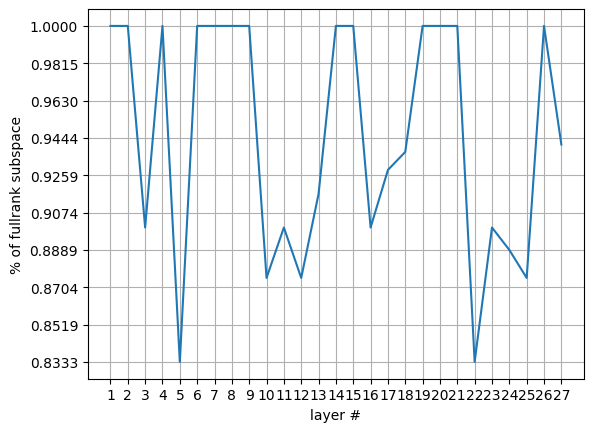

In [125]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
print(ypoints)
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

In [ ]:
threshold = 0.06

# comparing subspaces of mlp out
layer_names = [f'transformer.h.{idx}.mlp.fc_out.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, threshold = threshold)

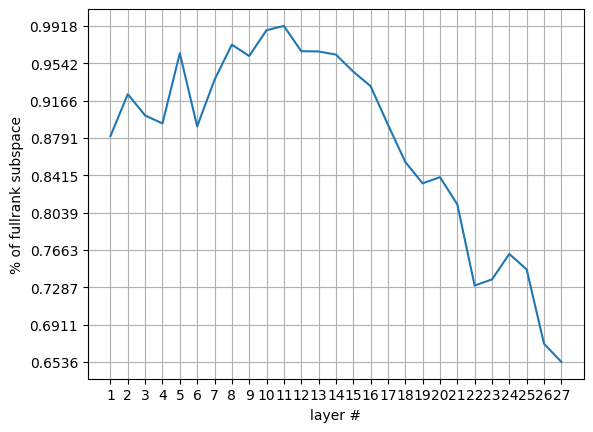

In [ ]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

In [ ]:
threshold = 0.06
rows_removed = 1

# comparing subspaces of attention key matrix
layer_names = [f'transformer.h.{idx}.attn.k_proj.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, threshold = threshold, rows_removed = rows_removed)

100%|██████████| 27/27 [14:54<00:00, 33.14s/it]


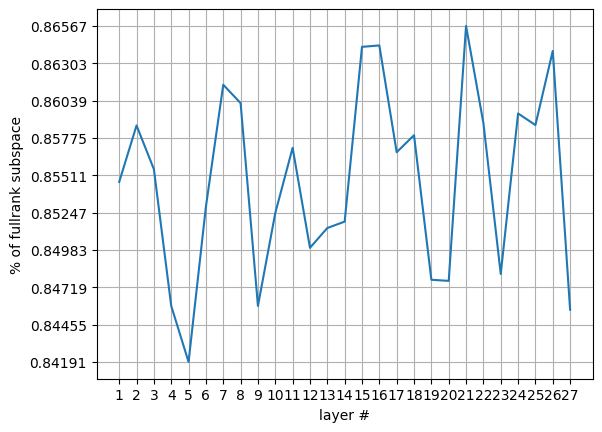

In [ ]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

In [ ]:
threshold = 0.06
rows_removed = 1

# comparing subspaces of mlp in
layer_names = [f'transformer.h.{idx}.mlp.fc_in.weight' for idx in range(28)]
spaces = compare_all_subspaces(layer_names, threshold = threshold, rows_removed = rows_removed)

100%|██████████| 27/27 [14:56<00:00, 33.22s/it]


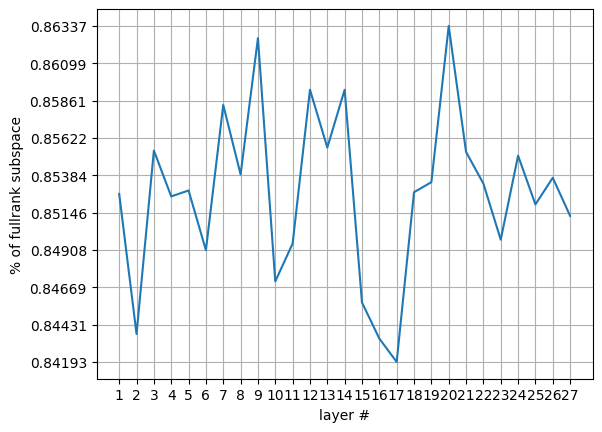

In [ ]:
ypoints = [s['percentage'] for s in spaces]
xpoints = [idx for idx in range(1,28)]
basic_plot(xpoints, ypoints, 'layer #', "% of fullrank subspace")

## Exploring the diagonal

In [51]:
m1 = params_dict[f'transformer.h.0.mlp.fc_out.weight']
m2 = params_dict[f'transformer.h.26.mlp.fc_out.weight']
m3 = params_dict[f'transformer.h.18.mlp.fc_out.weight']

U1, S1, V1 = torch.svd(m1)
U2, S2, V2 = torch.svd(m2)
U3, S3, V3 = torch.svd(m3)
# print(cuda2cpu_tensor2numpy(V1).shape)
# print(cuda2cpu_tensor2numpy(S1).shape)
m1 = cuda2cpu_tensor2numpy(U1)
m2 = cuda2cpu_tensor2numpy(U2)
m3 = cuda2cpu_tensor2numpy(U3)

# def find_norms(matrix):
#   matrix = np.dot(np.transpose(matrix), matrix)
#   l2_norm_array = np.diagonal(matrix) ** 0.5
#   return np.round(l2_norm_array)

In [59]:
small_epsilon = 0.02

def almost_orthogonal(matrix, small_epsilon):
  return np.count_nonzero(np.abs(np.diagonal(matrix)) < small_epsilon)

print(m1.shape)
almost_orthogonal(m1, small_epsilon)

(4096, 4096)


3238

In [60]:
almost_orthogonal(m3, small_epsilon)

3276

In [61]:
almost_orthogonal(m2, small_epsilon)

3296

In [56]:
def compare_diagonals(layer_names, small_epsilon = 0.02, v_matrix = True):
  spaces_lst = []
  for idx in tqdm(range(len(layer_names)-1)):
    m1 = params_dict[layer_names[idx]]
    m2 = params_dict[layer_names[idx+1]]

    U1, S1, V1 = torch.svd(m1)
    U2, S2, V2 = torch.svd(m2)

    if v_matrix:
      m1 = cuda2cpu_tensor2numpy(V1)
      m2 = cuda2cpu_tensor2numpy(V2)
    else:
      m1 = cuda2cpu_tensor2numpy(U1)
      m2 = cuda2cpu_tensor2numpy(U2)

    spaces_lst.append(almost_orthogonal(m2, small_epsilon)/almost_orthogonal(m1, small_epsilon))

  return spaces_lst

In [57]:
layer_names = [f'transformer.h.{idx}.mlp.fc_out.weight' for idx in range(28)]
diags = compare_diagonals(layer_names)

100%|██████████| 27/27 [02:03<00:00,  4.56s/it]


[1.1428571428571428, 0.9583333333333334, 1.127659574468085, 0.9622641509433962, 0.75, 1.0681818181818181, 1.0952380952380953, 1.1555555555555554, 0.9056603773584906, 1.0, 1.0196078431372548, 1.1176470588235294, 0.9622641509433962, 1.1132075471698113, 0.796875, 1.0192307692307692, 0.7358490566037735, 1.1842105263157894, 1.4871794871794872, 0.5818181818181818, 1.1818181818181819, 1.0952380952380953, 1.175, 1.069767441860465, 0.8, 1.2093023255813953, 1.0]


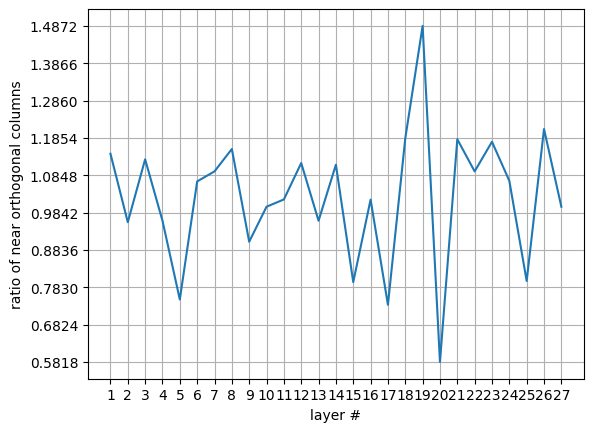

In [58]:
ypoints = diags
xpoints = [idx for idx in range(1,28)]
print(ypoints)
basic_plot(xpoints, ypoints, 'layer #', "ratio of near orthogonal columns")